# Conformal Predictions for ML Models (Dupont)

<a id='library_imports'></a>
## Library Imports

Prepare necessary modules and environments for notebook

In [1]:
#Load Modules
import dotenv
dotenv.load_dotenv(".env")
import prolerep.analysis.utils as utils
import mlflow.sklearn
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [47]:
original_dataset = utils.read_csv_from_s3("s3://prolerep/datasets/galapagos_38.csv.gz") #Upload original dataset from MLFlow
original_dataset.head()

,TESTSET,sequence,OBJECTID,variable,detergent,substrate,reference_sequence,task,output,new_host,temperature
0,GALAPAGOS-ARIEL-HDL-BMI,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,GG36-16743,pi[GG36-WT-STD],Ariel,BMI,AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGG...,activity,1.528320,NaN,NaN
1,GALAPAGOS-ARIEL-HDL-BMI,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,GG36-16579,pi[GG36-WT-STD],Ariel,BMI,AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGG...,activity,1.092288,NaN,NaN
2,GALAPAGOS-ARIEL-HDL-BMI,-AQAVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHGDLNI...,GG36-16020,pi[GG36-WT-STD],Ariel,BMI,AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGG...,activity,0.901811,NaN,NaN
3,GALAPAGOS-ARIEL-HDL-BMI,-AQAVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLNI...,GG36-15970,pi[GG36-WT-STD],Ariel,BMI,AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGG...,activity,0.000000,NaN,NaN
4,GALAPAGOS-ARIEL-HDL-BMI,-AQAVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLNI...,GG36-15979,pi[GG36-WT-STD],Ariel,BMI,AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGG...,activity,0.973300,NaN,NaN


In [3]:
'Submit MLflow Model'
#!prolerep submit-experiment ./ --username JohnB --follow search_random CP_Expression "s3://prolerep/datasets/galapagos_38.csv.gz" expression --metric spearman

'Submit MLflow Model'

**Step 1:** Load Expression Dataset from MLFlow

In [4]:
expression_df = utils.read_csv_from_s3("s3://mlflow/26/7b26c72eb9a54d2886334620cbd03313/artifacts/dataset.csv") #Upload split dataset from MLFlow
expression_df.head()

,new_host,sequence,expression,split
0,False,--AQVPYGVSQIKAPALH-SQGYTGQNVKVAVIDTGIDSSHEDLKV...,0.039268,valid
1,False,--ASVPYGVSQIKAPALH-SQGYTGSNVKVAVIDSGIDSSHPDLKV...,0.039268,train
2,False,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,0.261457,train
3,False,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,0.265189,valid
4,False,-AQAVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHGDLNI...,0.419681,train


**Step 2:** Seperate dataset into train and validation

In [5]:
def expression_data_split(df):
    #df = df[["sequence", "new_host", "split", "expression"]]  # rearrange dataframe columns
    train = df.loc[df["split"] == "train"]
    valid = df.loc[df["split"] == "valid"]
    # Expression Data
    x_train = train[["sequence", "new_host", "split"]]
    y_train = train[["expression"]]
    x_valid = valid[["sequence", "new_host", "split"]]
    y_valid = valid[["expression"]]
    #Convert y dataframes into arrays
    y_valid = y_valid.values
    y_train = y_train.values
    print("Data has been split")
    print("x_train and y_train shape: "+ str(x_train.shape) + str(y_train.shape))
    print("x_valid and y_valid shape: "+ str(x_valid.shape) + str(y_valid.shape))
    print('{} instances, {} features, {} classes'.format(y_train.size,
                                                   x_train.shape[1],
                                                   np.unique(y_train).size))
    return x_train, x_valid, y_train, y_valid

In [6]:
x_train, x_valid, y_train, y_valid = expression_data_split(expression_df)

Data has been split
x_train and y_train shape: (10933, 3)(10933, 1)
x_valid and y_valid shape: (7288, 3)(7288, 1)
10933 instances, 3 features, 9713 classes


**Step 3:** Load Expression_Model (Underlying Model)
* *Note: This model was previously trained to predict expression as target*

In [7]:
'Underyling Predictive Model: Target for Expression Levels'
expression_model = mlflow.sklearn.load_model("runs:/cece934af5944700ab5928922b422f20/logged_model")
#Expression_Model

**Step 4:** Calculate point predictions


In [8]:
valid_point_predictions = expression_model.predict(x_valid)
print("Point predictions have been estabilshed")
#valid_point_predictions

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Point predictions have been estabilshed


**Step 5**: Revise Expression Model Performance

In [9]:
print("R2 score : %.2f" % r2_score(y_valid, valid_point_predictions))
print("MSE score : %.2f" % mean_squared_error(y_valid, valid_point_predictions))

R2 score : 0.51
MSE score : 0.04


**Step 6:** Determine prediction errors of point predictions in calibration set

In [10]:
def calculate_residuals(predictions, true_labels):
    '''
    Calculates residuals of predicted labels vs true_labels 
    For each correct output in ``y``, nonconformity is defined as
    math::
    | y_i (predicted labels) - y^_i (true labels) |     
    
    @params
    true_labels is a numpy array of (true) labels 
    predictions is a numpy array of predicted labels
        
    Returns:
    Residual scores: numpy array of shape [n_samples]
    Residual scores of samples
    '''
    true_labels =  true_labels.flatten()
    predictions = predictions.flatten()
    residuals = np.abs(predictions - true_labels)
    
    print("Residuals have been calcualted ")
        
    return residuals

In [11]:
underlying_residuals = calculate_residuals(valid_point_predictions, y_valid)
#underlying_residuals

Residuals have been calcualted 


**Step 7:** Create new dataset (For training residuals model)

In [17]:
#task = ['residuals'] * len(x_valid)
#x_valid['task'] = task
#x_valid['output'] = underlying_residuals
#x_valid['expression'] = y_valid
#x_valid
#x_valid.to_csv(r'/home/john/Dupont_Internship/CP/CP_Residuals/dataframe_residuals_expression.csv', index = False)
#x_valid_residuals = utils.read_csv_from_s3('s3://prolerep/datasets/dataframe_residuals_expression.csv')

**Step 8:** Load split residuals df

In [21]:
residuals_df = utils.read_csv_from_s3("s3://mlflow/33/d5f6c0c295954da2888dbe9578ae271c/artifacts/dataset.csv")
residuals_df

,expression,new_host,sequence,residuals,split
0,0.039268,False,--AQVPYGVSQIKAPALH-SQGYTGQNVKVAVIDTGIDSSHEDLKV...,0.796240,train
1,0.039268,False,-AQIVPYGIPLIKADKVQ-AQGFKGANVKVSVLDTGIQASHPDLNV...,0.952799,valid
2,0.039268,False,-AQPVPYGVSQIKAPALH-AQGYTGANVKVAVIDSGIDSSHPDLKV...,0.814901,valid
3,0.039268,False,-AQPVPYGVSQIKAPALH-SQGYTGQNVKVAVIDTGIDSSHEDLKV...,0.970637,train
4,0.039268,False,-AQQVPYGIPLIKADKVQ-AQGFKGANVKVAVLDTGIQASHPDLNV...,0.946213,train
...,...,...,...,...,...
7283,0.999287,False,-AQSVPWGISRVQAPAAH-NRGLRGSGVKVAVLDTGI-STHPDLNI...,0.951015,train
7284,0.999506,False,-AQSVPWGISRVQAPAAH-NRGLRGSGVKVAVLDTGI-STHPDLNI...,0.819155,train
7285,0.999561,False,-AQSVPWGISRVQAPAAH-NRGLRGSGVKVAVLDTGI-STHPDLNI...,0.895856,train
7286,0.999726,False,-AQSVPWGISRVQAPAAH-NRGLRGSGVKVAVLDTGI-STHPDLNI...,0.856888,valid


In [22]:
def residual_data_split(residuals_df):
    cal = residuals_df.loc[residuals_df["split"] == "train"]
    test = residuals_df.loc[residuals_df["split"] == "valid"]
    # Residuals Dataset
    x_cal= cal[["sequence", "new_host", "split", "expression"]]
    y_cal = cal[["residuals"]]
    x_test = test[["sequence", "new_host", "split", "expression"]]
    y_test = test[["residuals"]]
    #Convert y dataframes into arrays
    y_test = y_test.values
    y_cal = y_cal.values
    print("Data has been split")
    print("x_cal and y_cal shape: "+ str(x_cal.shape) + str(y_cal.shape))
    print("x_test and y_test shape: "+ str(x_test.shape) + str(y_test.shape))
    print('{} instances, {} features, {} classes'.format(y_cal.size,
                                                   x_cal.shape[1],
                                                   np.unique(y_cal).size))
    return x_cal, x_test, y_cal, y_test

In [23]:
x_cal, x_test, y_cal, y_test = residual_data_split(residuals_df)

Data has been split
x_cal and y_cal shape: (5102, 4)(5102, 1)
x_test and y_test shape: (2186, 4)(2186, 1)
5102 instances, 4 features, 5102 classes


**Step 9:** Load Residual_Model
* *Note: This model was previously trained to predict residual as target*

In [24]:
'Error Model for predicting residuals'
residual_model = mlflow.sklearn.load_model("runs:/89bac0691d45490a91793ef7afcabbad/logged_model")
#residual_model

**Step 10:** Predict residuals using residual model

* *Note: These will be used to normalize the conformal scores*

In [25]:
predicted_residuals = residual_model.predict(x_cal) 
#predicted_residuals

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


**Step 11**: Evaluate residual model performance

In [26]:
print("R2 score : %.2f" % r2_score(y_cal, predicted_residuals))
print("MSE score : %.2f" % mean_squared_error(y_cal, predicted_residuals))

R2 score : 0.27
MSE score : 0.06


**Step 12:** Obtain calibration point predictions

In [27]:
calibration_predictions = expression_model.predict(x_cal)
calibration_predictions

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([[0.27288139],
       [0.52578398],
       [0.44898125],
       ...,
       [0.58018471],
       [0.749941  ],
       [0.67796252]])

**Step 12:** Obtain Conformal Scores

In [28]:
def calculate_nonconformity(predictions, true_labels):
    '''
    Calculates absolute error nonconformity scores for data set.
    For each correct output in ``y``, nonconformity is defined as
    :
    | y_i (predicted labels) - y^_i (true labels) |     
    
    @params
    true_labels is a numpy array of (true) labels 
    predictions is a numpy array of predicted labels
    predicted_residuals is a numpy array of predicted_residuals (These are already flattened)
        
    Returns:
    conformal scores: numpy array of shape [n_samples]
    '''
    
    true_labels =  true_labels.flatten()
    predictions = predictions.flatten()
    conformal_scores = np.abs(true_labels - predictions)
    
    print("Conformal Scores Obtained")
        
    return conformal_scores

*Note: Need to redefine expression target from x_cal: expression*

In [29]:
expression_target = x_cal["expression"]
expression_target = expression_target.values
#expression_target

In [30]:
conformal_scores = calculate_nonconformity(calibration_predictions, expression_target)
#conformal_scores

Conformal Scores Obtained


**Step 13:** Normalize Conformal Scores

In [32]:
def normalize_scores(conformal_scores, predicted_residuals, beta):
    '''
    Normalize the conformal scores to generate tighter prediction intervals
    and reduce the size of these.
    
    @params
    conformal_scores: 
    
    Returns
    normal_scores: numpy array of shape [n_samples]
    Normalized conformal scores of the samples
    '''
    
    normalized_scores = conformal_scores / (predicted_residuals + beta)
    #normalized_scores = np.exp(normalized_scores)
    normalized_scores = normalized_scores.flatten()
    normalized_scores = np.sort(normalized_scores)[::-1] #sort in descending order
    
    return normalized_scores

In [33]:
normalized_conformal_scores = normalize_scores(conformal_scores, predicted_residuals, beta = 0.05)

**Step 14:** Get confidence percentile

In [35]:
def get_alpha_index(conformal_scores, significance):
    '''
    Determine the confidence percentile and applies the inverse of the nonconformity function
    in order to calculate the limits of the prediction intervals
    
    @params
    conformal_scores: Nonconformity scores obtained from the conformal predictor [n_calibration_samples]
    significance: Float value between 0-1 (i.e. 0.05)
        
    Returns:
        
    Interval Limits: Numpy array of shape [n_samples, 2] that determines 
    the min and max interval boundaries for each prediction interval        
    '''
    
    confidence_percentile = int(np.floor(significance * (normalized_conformal_scores.size + 1))) - 1 # Calculate the confidence percentile
    index = min(max(confidence_percentile, 0), normalized_conformal_scores.size - 1)
    alpha_percentile = normalized_conformal_scores[index]
    
    return alpha_percentile

In [48]:
#alpha_percentile = np.quantile(normalized_conformal_scores, 0.70, interpolation='lower')
alpha_percentile = get_alpha_index(normalized_conformal_scores, significance = 0.30)
alpha_percentile

0.3508348516463597

**Step 15:** Define Test Predictions and residuals using expression and residual model


In [37]:
test_predictions = expression_model.predict(x_test)
predicted_test_residuals = residual_model.predict(x_test)

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


**Step 16:** Obtain Prediction Intervals and interval size

In [38]:
def get_intervals(test_predictions, test_residuals, alpha_percentile):
    """
    Function will construct the prediction intervals 
    for a set of test examples. 
        
    This applies the partial inverse nonconformity function
    to each prediction from the underlying model, thus
    resulting in a prediction interval for each test pattern.

    @params
        ----------
    test_predictions: Numpy array of shape [n_samples, n_features]
    test_residuals: predicted residuals of new samples using error_mode
    alpha_percentile: confidence percentile of normalized_conformal_scores

        
    Returns
    -------
    prediction_intervals : numpy array of shape [n_samples, 2]
    Interval Size: Array that contains the size of the predicted intervals

    When significance value is a float between 0 and 1, then p 
    contains the prediction intervals (minimum and maximum boundaries)
    for the set of test patterns at the chosen significance level.
    """
    
    lower_interval = test_predictions - (test_residuals * alpha_percentile)
    higher_interval = test_predictions + (test_residuals * alpha_percentile)
    prediction_intervals = np.hstack((lower_interval, higher_interval))
    interval_size = higher_interval - lower_interval #Efficiency measure

    print("Prediction Intervals Created")

    return prediction_intervals, interval_size


In [39]:
prediction_intervals,interval_size = get_intervals(test_predictions, predicted_test_residuals, alpha_percentile)
prediction_intervals

Prediction Intervals Created


array([[ 0.06957439,  0.85683295],
       [-0.03656993,  0.60811728],
       [ 0.30855335,  0.73856977],
       ...,
       [ 0.4979599 ,  0.9092292 ],
       [ 0.42805629,  1.01234245],
       [ 0.49263429,  0.83906651]])

**Step 17:** Evaluate Prediction Intervals

In [40]:
def get_evaluation_table(prediction_intervals, interval_size, y_test):
    '''
    Gives a final table that contains the prediction intervals, their size
    and original (true) labels of the test patterns. 
    Allows to determine efficiency of predictions
        
    @params
    predictions: Prediction intervals determined from the test patterns
    size: Size of the respective prediction intervals
    y: array of the true labels (i.e. y_test)
        
    returns:
        
    Tabulated results for the evaluation function
    ''' 
    
    min_interval = prediction_intervals[:, 0]
    max_interval = prediction_intervals[:, 1]
    min_interval = min_interval.flatten()
    max_interval = max_interval.flatten()
    interval_size = interval_size.flatten()
    y_test = y_test.flatten()
    evaluation_table = pd.DataFrame({'min':min_interval, 'max':max_interval, 'true': y_test, 'interval_size': interval_size})
    
    return evaluation_table

In [41]:
evaluation_table = get_evaluation_table(prediction_intervals, interval_size, y_test)
evaluation_table

,min,max,true,interval_size
0,0.069574,0.856833,0.952799,0.787259
1,-0.036570,0.608117,0.814901,0.644687
2,0.308553,0.738570,0.970225,0.430016
3,0.238773,0.674720,0.950192,0.435948
4,0.256899,0.666846,0.952387,0.409947
...,...,...,...,...
2181,0.560590,0.857755,0.867042,0.297166
2182,0.430914,0.810694,0.932492,0.379780
2183,0.497960,0.909229,0.872530,0.411269
2184,0.428056,1.012342,0.856888,0.584286


In [43]:
#Sort values by "interval_size"
sorted_table = evaluation_table.sort_values("interval_size")
plot_range = list(range(0,len(sorted_table)))
sorted_table['index'] = plot_range
sorted_table

,min,max,true,interval_size,index
1556,0.601652,0.528320,0.561745,-0.073332,0
480,0.523599,0.498344,0.883095,-0.025255,1
1855,0.912791,0.902850,0.307766,-0.009941,2
567,0.333309,0.331362,0.371707,-0.001947,3
1244,0.349828,0.371205,0.705818,0.021376,4
...,...,...,...,...,...
1901,-0.004901,0.796355,0.966383,0.801255,2181
499,-0.272099,0.534850,0.363474,0.806949,2182
523,0.481479,1.368654,0.993002,0.887175,2183
197,-0.288529,0.618601,0.526207,0.907130,2184


**Step 18:** Visualize prediction intervals

*Min and Max Intervals with True Labels* 

/home/john/my_python_env/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


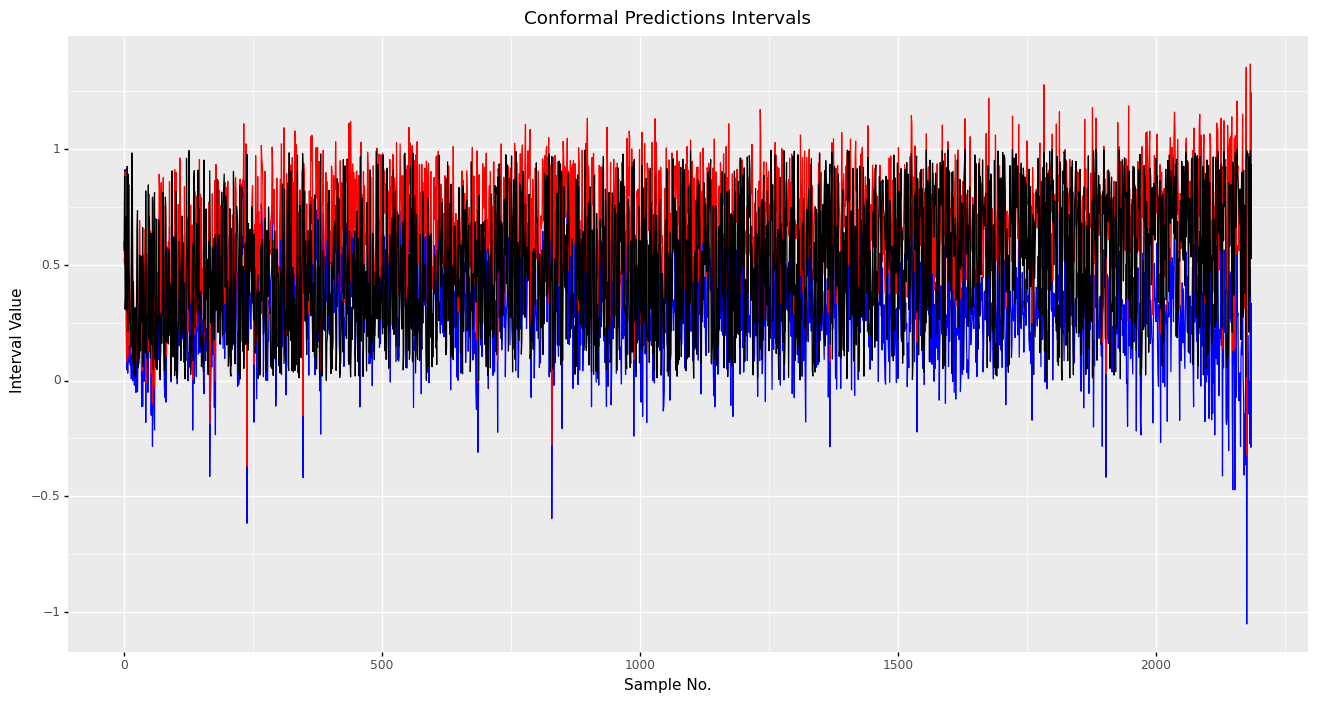

<ggplot: (8754113638649)>

In [44]:
import plotnine as p9
p9.options.set_option("figure_size", (16, 8))

(p9.ggplot(sorted_table, p9.aes(x = "index"))  # here
 + p9.geom_line(p9.aes(y = "min"), color = "blue")
 + p9.geom_line(p9.aes(y = "max"), color = "red")
 + p9.geom_line(p9.aes(y = "true"), color = "black")
 + p9.xlab("Sample No.")
 + p9.ylab("Interval Value")
 + p9.ggtitle("Conformal Predictions Intervals")
)  

*Residuals vs Interval Size* 

In [45]:
y_test_abs = np.abs(y_test)
interval_sizes = np.abs(evaluation_table["interval_size"].values)
residuals_vs_intervals = pd.DataFrame({'true_residuals': y_test_abs.flatten(), 'confidence_interval': interval_sizes})
##residuals_vs_intervals

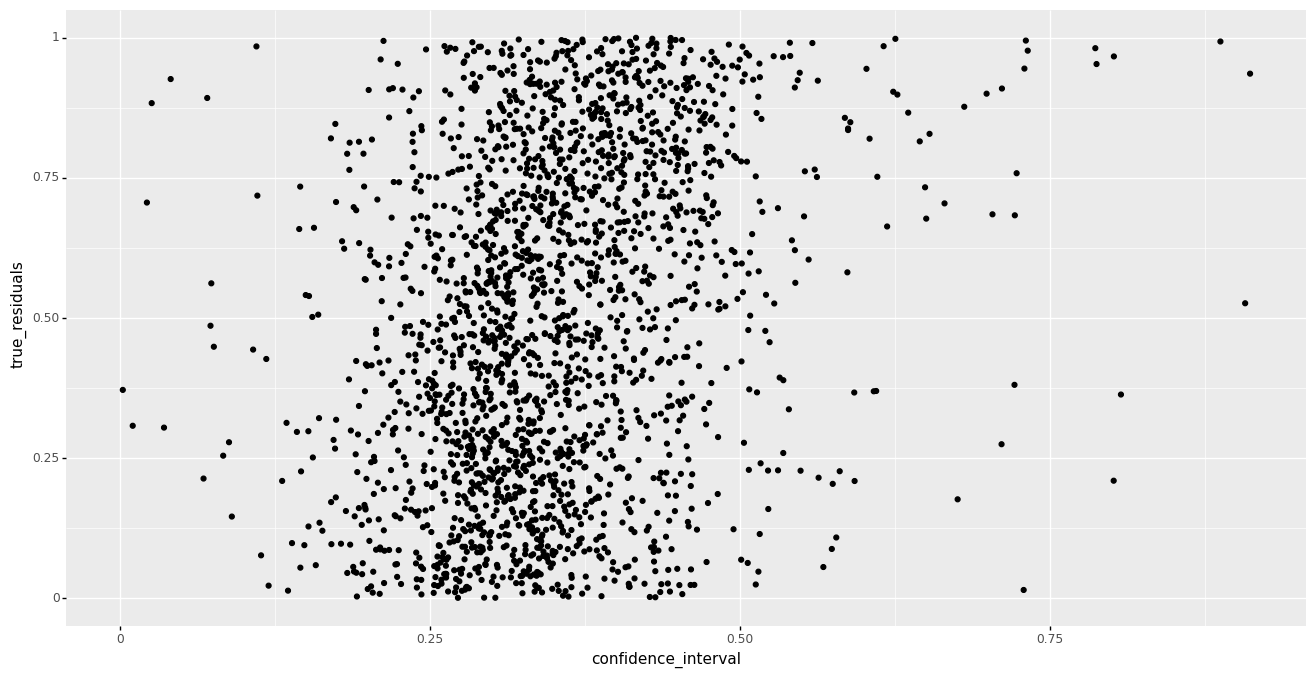

<ggplot: (8754113543397)>

In [46]:
import plotnine as p9
#Just based on the test dataset
p9.options.set_option("figure_size", (16, 8))
(p9.ggplot(residuals_vs_intervals, p9.aes("confidence_interval", "true_residuals"))
 + p9.geom_point()
)